# In this dataset

1. does it match the statistics of a high dimensional grid representation
2. Is the taurus real
3. test whether you can do the grid realignment like carpenter also in the big maze
4. show that correlation structure is preserved only in as far as cells are spatial

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import re
import seaborn
import pandas as pd
#import cv2
import scipy.optimize as op
import sys
import networkx as nx
import time
import matplotlib
import copy as cp
import scipy.ndimage as ndi 

import scipy as sp
import scipy.signal
seaborn.set(style='ticks',font_scale=1.5)


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# From pycontrol

In [3]:
sys.path.append('/Users/yves/Documents/Code/mec_ephys/packages')

#from mecll.rsync import Rsync_aligner
from mecll.load import load_data
from mecll.process_data.proc_beh import get_all_transitions, get_transitions_state, build_poke_df, get_in_task_pokes
from mecll.process_data.proc_neural import get_all_resps, get_mean_resps
from mecll.plot.plot_activity_on_graph import plot_activity_on_graph, plot_cell

# Actual code

In [35]:
#Load behavioural data
root_path = '/Users/yves/team_mouse Dropbox/MEC_data/spike_sorted/2021-08-06_39964_ks25/'
#'/Users/yves/Downloads/example_files2_wOF//'

out = load_data(root_path)
spkT,spkC,single_units,events,lines,aligner = out

567 567


In [36]:
#process task data
all_poke_dict = get_in_task_pokes(lines,events)

In [37]:
all_poke_dict[0]['graph_type']

'line'

In [38]:
all_poke_dict[1]['graph_type']

'loop'

In [39]:
df = build_poke_df(lines,events)
df['previous_port'][1:] = df['port'][:-1]
df['previous_state'][1:] = df['state'][:-1]

In [40]:
poke_dict_t1 ={}
poke_dict_t2 = {}
for port_nr in np.unique(df['port'].values):
    for task_nr in range(2):
        task_nr = str(task_nr)
        v = df.loc[(df['port']==port_nr) &
                   (df['correct']==True) & 
                   #(df['next_correct']==True) &
                   #(df['reward']==True) &
                   #(df['port_repeat']==False) & 
                   #(df['RT']<1600) &
                   (df['task_nr']==task_nr)
                  ]['time'].values
        #v = np.array(v).astype('float')
        if task_nr=='0':
            print(task_nr,len(v),str(port_nr))
            poke_dict_t1[str(port_nr)] = [float(i) for i in v]
        else:
            poke_dict_t2[str(port_nr)] = [float(i) for i in v]
            
        
        if port_nr==8:
            poke_dict_t1['task_nr'] = str(task_nr)
            poke_dict_t2['task_nr'] = str(task_nr)
            poke_dict_t1['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            poke_dict_t2['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            poke_dict_t1['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]
            poke_dict_t2['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]

0 16 0
0 50 1
0 36 2
0 35 3
0 45 4
0 24 5
0 28 6
0 41 7
0 26 8


In [41]:
tmp_ = get_all_resps(aligner,poke_dict_t1,single_units,spkT,spkC,window0=6000,window1=6000)
all_resps_g1_single_trial, (all_resps1_g1_single_trial,all_resps2_g1_single_trial)  = tmp_
tmp_ = get_all_resps(aligner,poke_dict_t2,single_units,spkT,spkC,window0=6000,window1=6000)
all_resps_g2_single_trial, (all_resps1_g2_single_trial,all_resps2_g2_single_trial) = tmp_

In [42]:
len(single_units)

201

In [43]:
def get_mean_resps(all_resps_single_trial):
    mus = []
    vs = []
    mu_g1 = []
    var_g1 = []
    for neuron in all_resps_single_trial:
        tmp_mu = []
        tmp_var = []
        for poke in neuron:
            tmp_mu.append(np.mean(poke))
            tmp_var.append(np.var(poke))
        mu_g1.append(tmp_mu)
        var_g1.append(tmp_var)

    return np.array(mu_g1),np.array(var_g1)

In [44]:
all_resps_g1,_ = get_mean_resps(all_resps_g1_single_trial)
all_resps_g2,_ = get_mean_resps(all_resps_g2_single_trial)


all_resps1_g1,_ = get_mean_resps(all_resps1_g1_single_trial)
all_resps1_g2,_ = get_mean_resps(all_resps1_g2_single_trial)

all_resps2_g1,_ = get_mean_resps(all_resps2_g1_single_trial)
all_resps2_g2,_ = get_mean_resps(all_resps2_g2_single_trial)

In [45]:
from sklearn.decomposition import pca

In [46]:
#
ccs_within1 = []
for r1,r2 in zip(all_resps1_g1,all_resps2_g1):
    ccs_within1.append(np.corrcoef(r1,r2)[0,1])
    
ccs_within1 = np.array(ccs_within1)
print(np.nanmean(ccs_within1))

0.5807073208971512


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [47]:
#
ccs_within2 = []
for r1,r2 in zip(all_resps1_g1,all_resps2_g1):
    ccs_within2.append(np.corrcoef(r1,r2))
    
ccs_within2 = np.array(ccs_within2)
print(np.nanmean(ccs_within2))

0.7936813801239949


In [48]:

#ax = seaborn.jointplot(ccs_within1,ccs_within2)
#ax.ax_joint.plot([-1,1],[-1,1])

#plt.ylim(-1,1)
#plt.xlim(-1,1)

In [49]:
from scipy.stats import spearmanr


In [50]:
spearmanr(all_resps1_g1[0],all_resps1_g2[0])

SpearmanrResult(correlation=-0.25, pvalue=0.5164895523012263)

In [51]:
ix = 1
np.corrcoef(all_resps1_g1[0],all_resps1_g2[1])

array([[1.        , 0.35555267],
       [0.35555267, 1.        ]])

In [52]:
#
ccs_within2 = []
for r1,r2 in zip(all_resps1_g2,all_resps2_g2):
    ccs_within2.append(np.corrcoef(r1,r2)[0,1])
ccs_within2 = np.array(ccs_within2)

print(np.nanmean(ccs_within2))

0.5817864246375465


In [53]:
ccs_both = np.vstack([ccs_within1,ccs_within2])

In [54]:
ccs_within = (np.array(ccs_within1) + np.array(ccs_within2))/2.
ccs_within = np.min(np.vstack([np.array(ccs_within1),np.array(ccs_within2)]),axis=0)

In [55]:
#
ccs_across = []
for r1,r2 in zip(all_resps_g1,all_resps_g2):
    ccs_across.append(np.corrcoef(r1,r2)[0,1])
    
ccs_across = np.array(ccs_across)
print(np.nanmean(ccs_across))

0.5923544305807923


Text(0, 0.5, 'within_task2 stability')

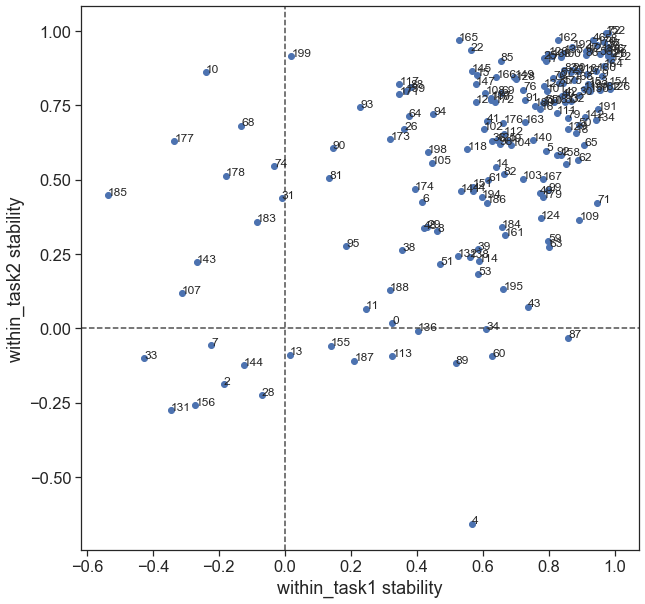

In [56]:
plt.figure(figsize=(10,10))
plt.scatter(ccs_within1,ccs_within2)
plt.axvline(x=0,color='.3',linestyle='--')
plt.axhline(y=0,color='.3',linestyle='--')
for i, txt in enumerate(ccs_across):
    plt.gca().annotate(i, (ccs_within1[i], ccs_within2[i]),fontsize=12)

plt.xlabel('within_task1 stability')
plt.ylabel('within_task2 stability')

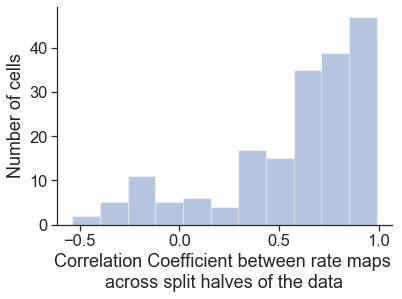

In [57]:
seaborn.distplot(np.array(ccs_within1)[np.isfinite(ccs_within1)],kde=0)
plt.xlabel("Correlation Coefficient between rate maps \nacross split halves of the data")
plt.ylabel("Number of cells")
seaborn.despine()

Text(0.5, 0, 'Mean firing rate')

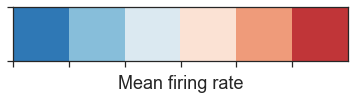

In [58]:
seaborn.palplot(seaborn.color_palette('RdBu_r'),)
plt.xlabel('Mean firing rate')

Text(0, 0.5, 'within_task_stability')

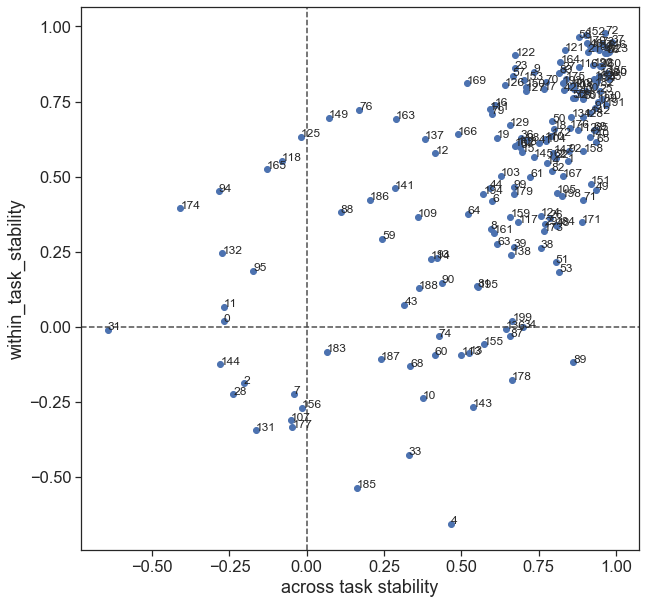

In [59]:
plt.figure(figsize=(10,10))
plt.scatter(ccs_across,ccs_within)
plt.axvline(x=0,color='.3',linestyle='--')
plt.axhline(y=0,color='.3',linestyle='--')
for i, txt in enumerate(ccs_across):
    plt.gca().annotate(i, (ccs_across[i], ccs_within[i]),fontsize=12)

plt.xlabel('across task stability')
plt.ylabel('within_task_stability')

In [60]:
#plot_cell(28,all_resps_g1,all_resps_g2,all_poke_dict,norm=True,norm_pct=99)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


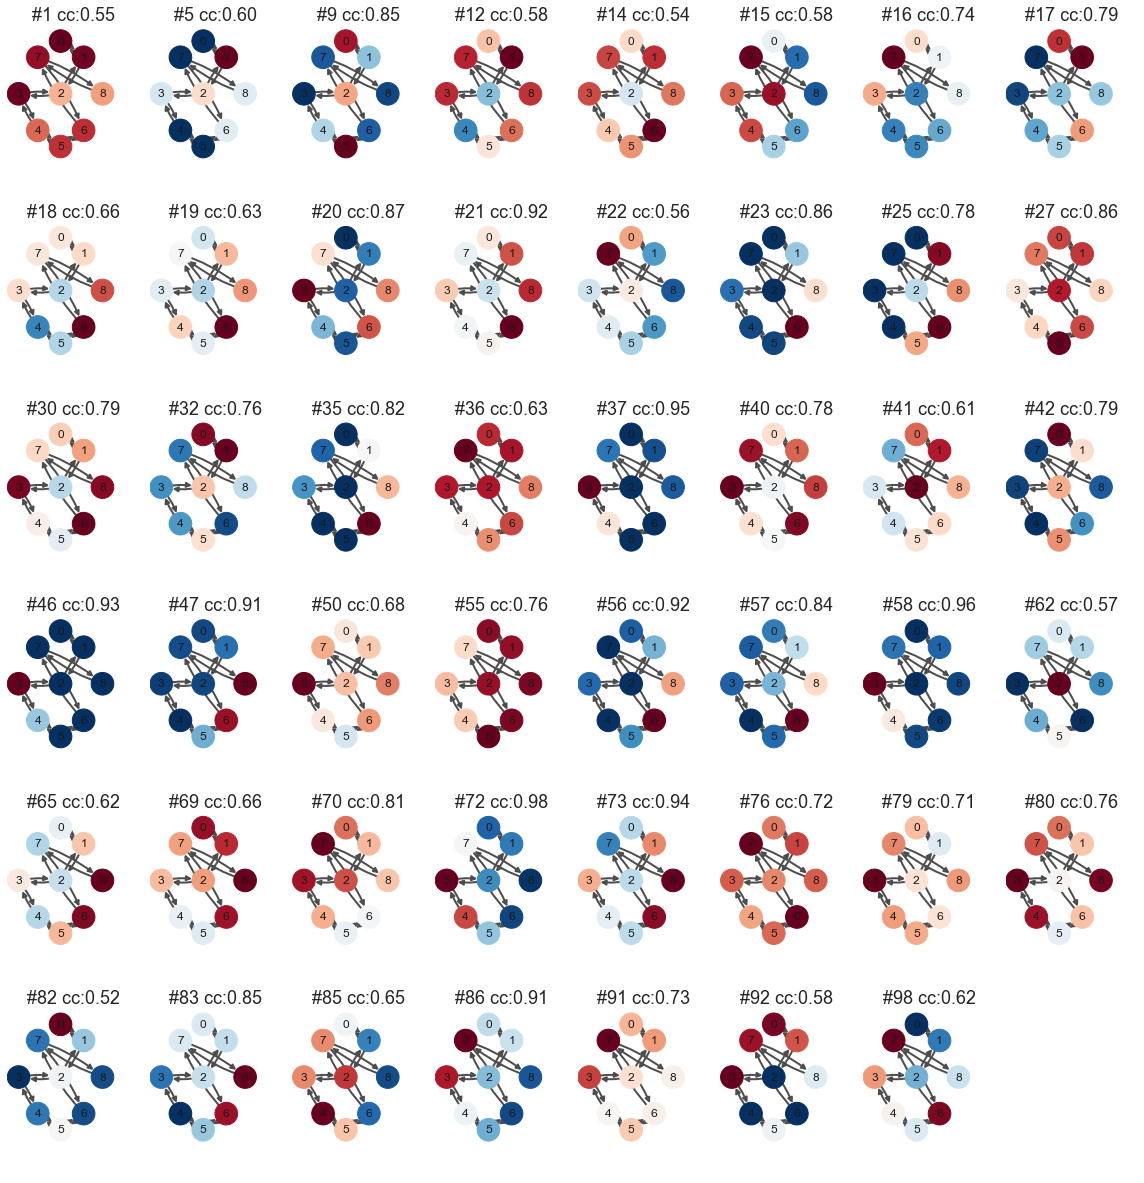

In [61]:
plt.figure(figsize=(16,22))
ctr = 0
for ctr_,spks in enumerate(all_resps1_g2[:100]):
    if ccs_within[ctr_]>0.5:
        plt.subplot(8,8,ctr+1)
        plt.title('#'+str(ctr_) + ' cc:' + '{:.2f}'.format(ccs_within[ctr_]))
        #nx.draw_circular(G,node_color=spks,node_size=512)
        plot_activity_on_graph(all_poke_dict[0]['seq'],'line',spks=spks,order='poke',node_size=512)
        axis = plt.gca()
        # maybe smaller factors work as well, but 1.1 works fine for this minimal example
        axis.set_xlim([1.3*x for x in axis.get_xlim()])
        axis.set_ylim([1.3*y for y in axis.get_ylim()])
        ctr+= 1

plt.tight_layout()

In [62]:
all_resps_g1.shape

(201, 9)

In [63]:
all_resps_g2.shape

(201, 9)

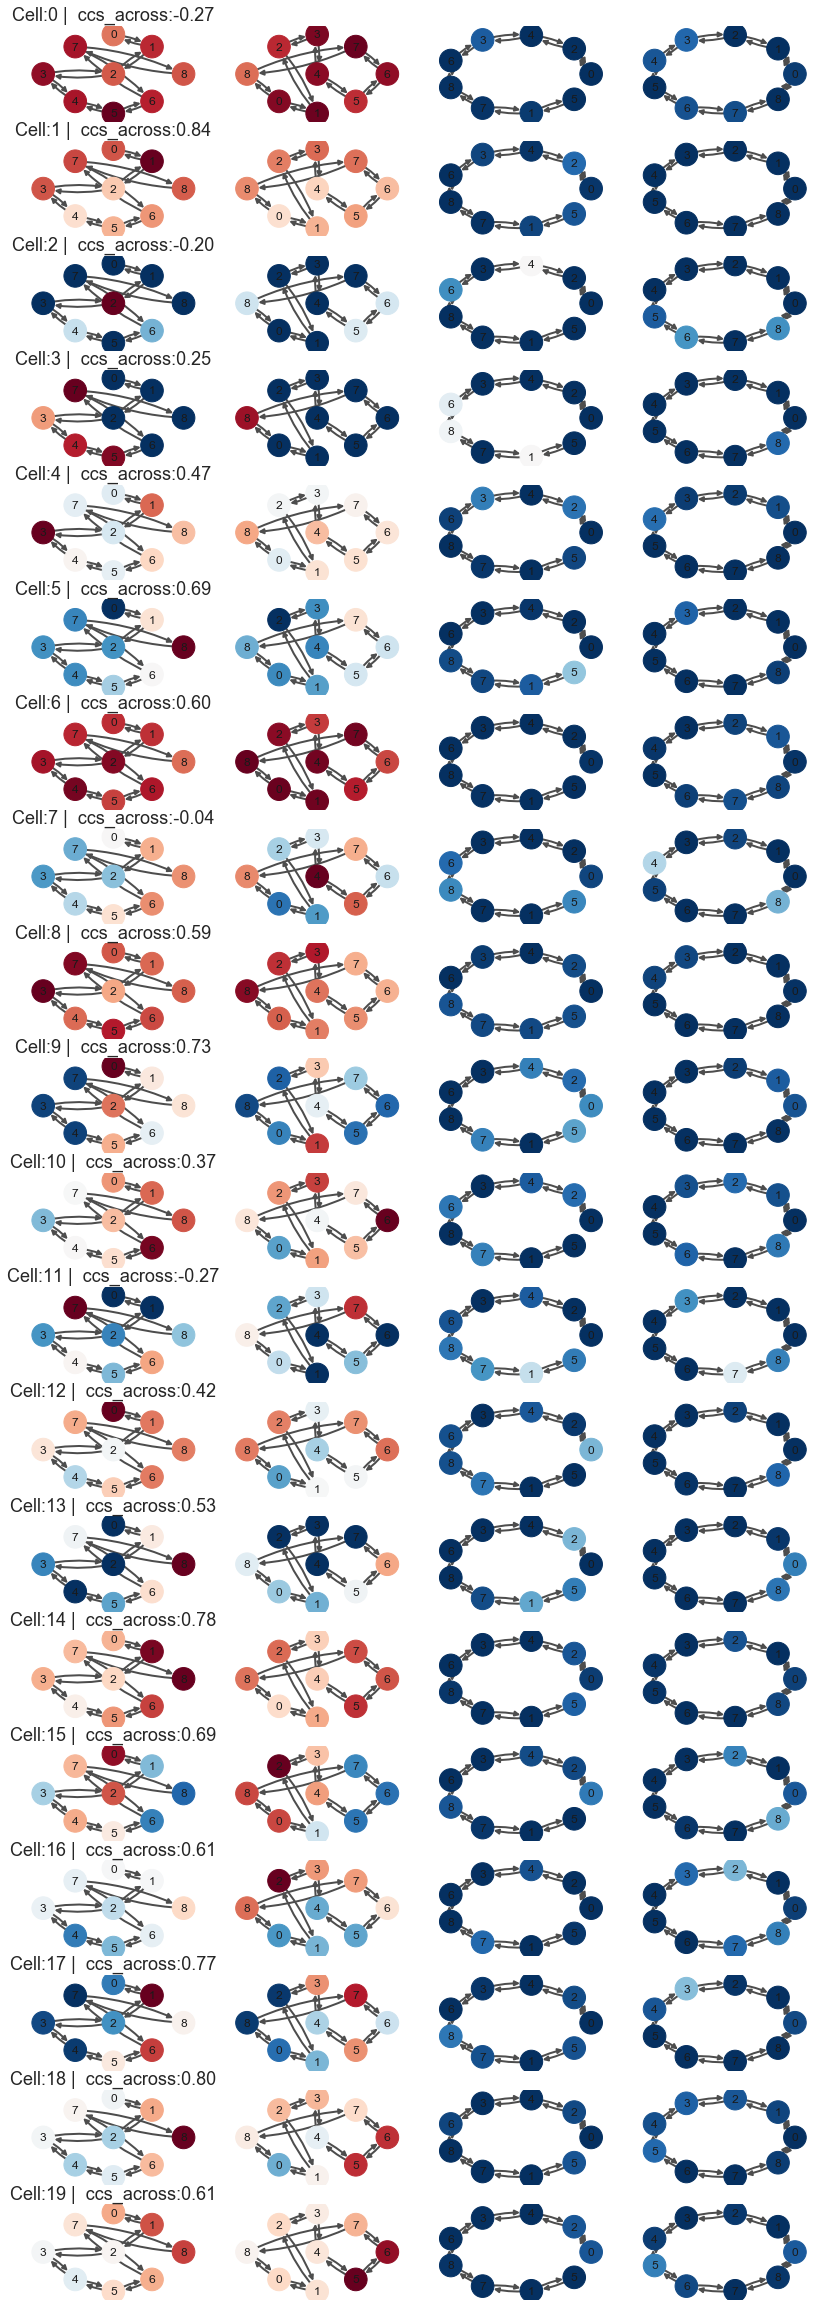

In [64]:
mean_resps_state = (all_resps_g1 + all_resps_g2)/2.

resps_state_g1 = (all_resps_g1-mean_resps_state)[:,all_poke_dict[0]['seq']]
resps_state_g2 = (all_resps_g2-mean_resps_state)[:,all_poke_dict[1]['seq']]
plt.figure(figsize=(14,84))

n_plot = 40
start = 0
ctr = 0
for i in range(20):#len(ccs_within)):
    if True:#ccs_within[i]>0.3 and ccs_across[i]<0.6:
        spks1 = all_resps_g1[i]# - ( all_resps_g1[i]+ all_resps_g2[i])/2.
        spks2 = all_resps_g2[i]# - ( all_resps_g1[i]+ all_resps_g2[i])/2.
        mx = np.nanmax(np.concatenate([spks1,spks2]))
        mn = 0#np.nanmin(np.concatenate([spks1,spks2]))
        plt.subplot(n_plot,4,4*ctr+1)
        plt.title('Cell:{} |  ccs_across:{:.2f}'.format(i,ccs_across[i]))

        spks = spks1
        plot_activity_on_graph(all_poke_dict[0]['seq'],all_poke_dict[0]['graph_type'],
                               spks=spks,order='poke',mx=mx,mn=mn)
        
        plt.subplot(n_plot,4,4*ctr+2)
        spks = spks2
        plot_activity_on_graph(all_poke_dict[1]['seq'],all_poke_dict[1]['graph_type'],
                               spks=spks,order='poke',mx=mx,mn=mn)

        plt.subplot(n_plot,4,4*ctr+3)
        spks = resps_state_g1[i]
        plot_activity_on_graph(all_poke_dict[0]['seq'],all_poke_dict[0]['graph_type'],
                               spks=spks,order='state',mx=mx,mn=mn)
        
        plt.subplot(n_plot,4,4*ctr+4)
        spks = resps_state_g2[i]
        plot_activity_on_graph(np.arange(9).tolist(),all_poke_dict[1]['graph_type'],
                               spks=spks,order='state',mx=mx,mn=mn)

        ctr +=1

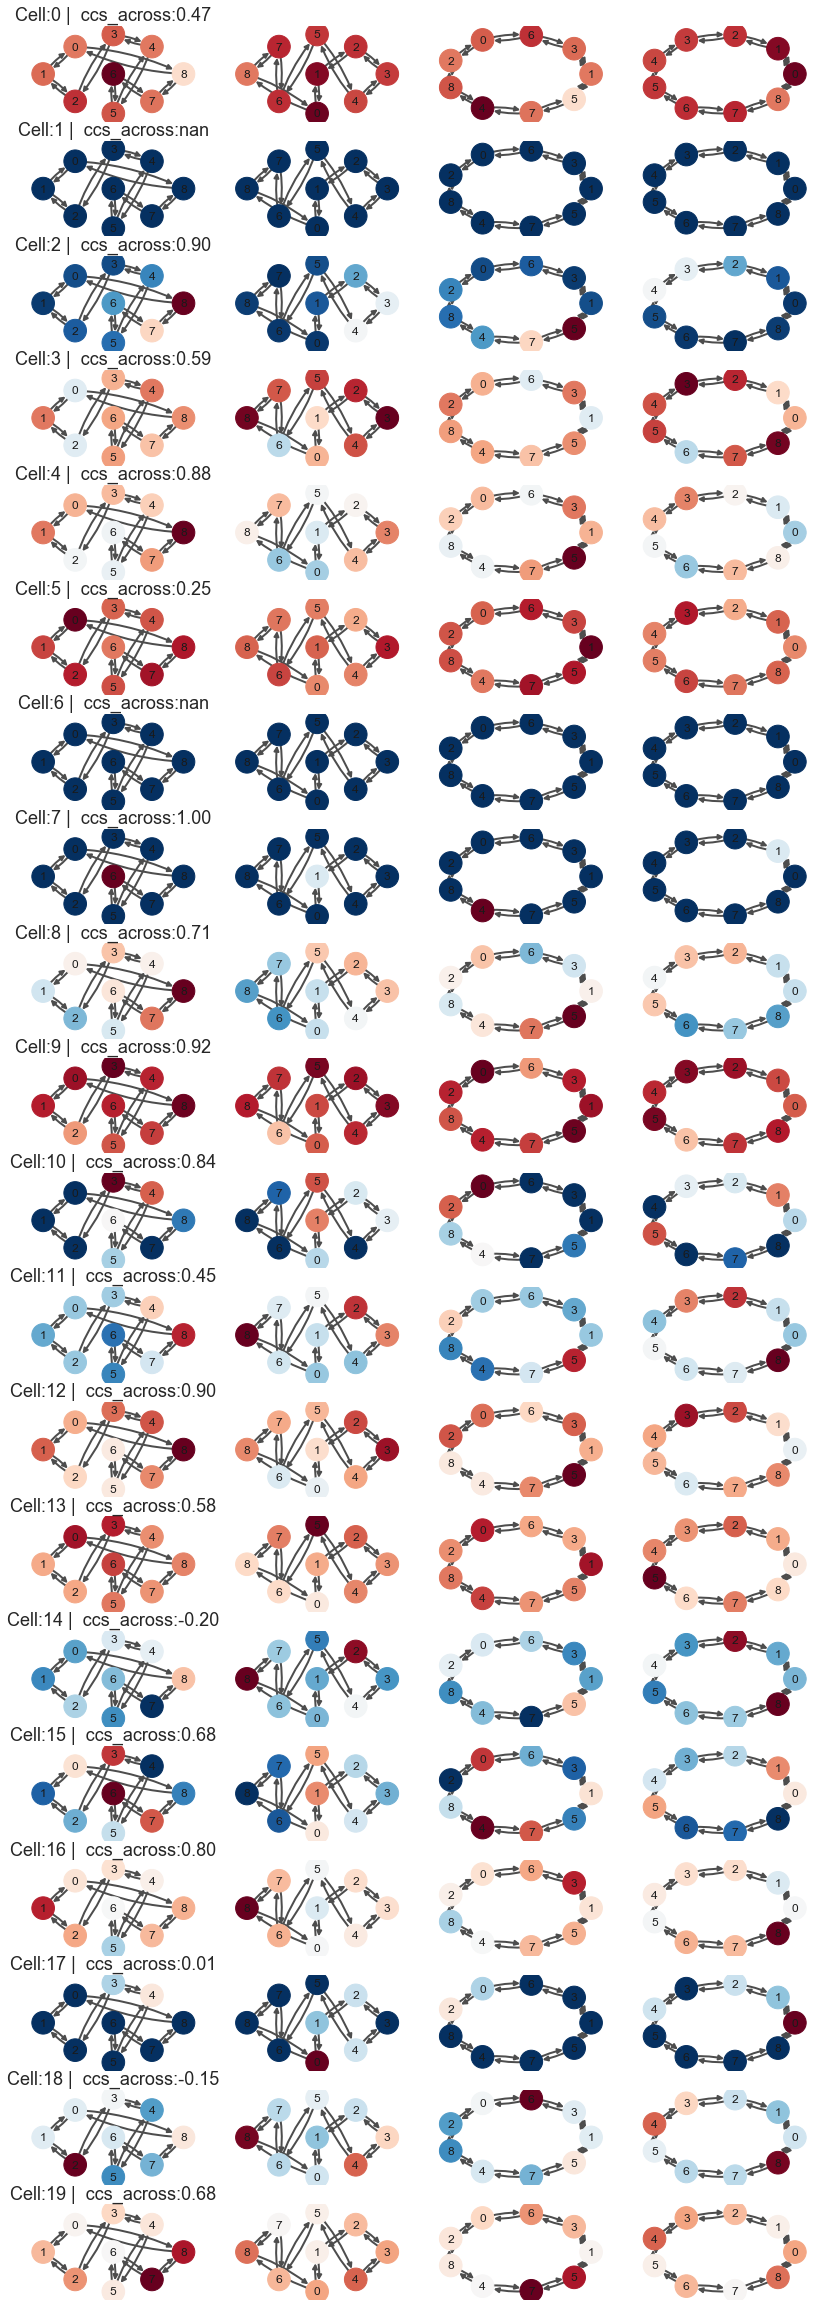

In [34]:
resps_state_g1 = all_resps_g1[:,all_poke_dict[0]['seq']]
resps_state_g2 = all_resps_g2[:,all_poke_dict[1]['seq']]
plt.figure(figsize=(14,84))

n_plot = 40
start = 0
ctr = 0
for i in range(20):#len(ccs_within)):
    if True:#ccs_within[i]>0.3 and ccs_across[i]<0.6:
        spks1 = all_resps_g1[i]# - ( all_resps_g1[i]+ all_resps_g2[i])/2.
        spks2 = all_resps_g2[i]# - ( all_resps_g1[i]+ all_resps_g2[i])/2.
        mx = np.nanmax(np.concatenate([spks1,spks2]))
        mn = 0#np.nanmin(np.concatenate([spks1,spks2]))
        plt.subplot(n_plot,4,4*ctr+1)
        plt.title('Cell:{} |  ccs_across:{:.2f}'.format(i,ccs_across[i]))

        spks = spks1
        plot_activity_on_graph(all_poke_dict[0]['seq'],all_poke_dict[0]['graph_type'],
                               spks=spks,order='poke',mx=mx,mn=mn)
        
        plt.subplot(n_plot,4,4*ctr+2)
        spks = spks2
        plot_activity_on_graph(all_poke_dict[1]['seq'],all_poke_dict[1]['graph_type'],
                               spks=spks,order='poke',mx=mx,mn=mn)

        plt.subplot(n_plot,4,4*ctr+3)
        spks = resps_state_g1[i]
        plot_activity_on_graph(all_poke_dict[0]['seq'],all_poke_dict[0]['graph_type'],
                               spks=spks,order='state',mx=mx,mn=mn)
        
        plt.subplot(n_plot,4,4*ctr+4)
        spks = resps_state_g2[i]
        plot_activity_on_graph(np.arange(9).tolist(),all_poke_dict[1]['graph_type'],
                               spks=spks,order='state',mx=mx,mn=mn)

        ctr +=1

In [179]:
import scipy.stats as stt

In [34]:
stt.ttest_ind(ccs_across[np.isfinite(ccs_across)],ccs_across[[148,132,134,113,123,267,275]])

IndexError: index 267 is out of bounds for axis 0 with size 201

ValueError: cannot convert float NaN to integer

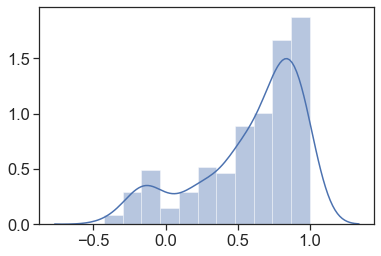

In [78]:
seaborn.distplot(ccs_across[np.isfinite(ccs_across)],kde=1)
seaborn.distplot(ccs_across[[148,132,134,113,123,267,275]],kde=1)

In [113]:
len([ 36,  78,  84,  99, 113, 115, 116, 117, 132, 133, 140, 148,
       220, 258, 265, 270, 274, 275, 312])

19

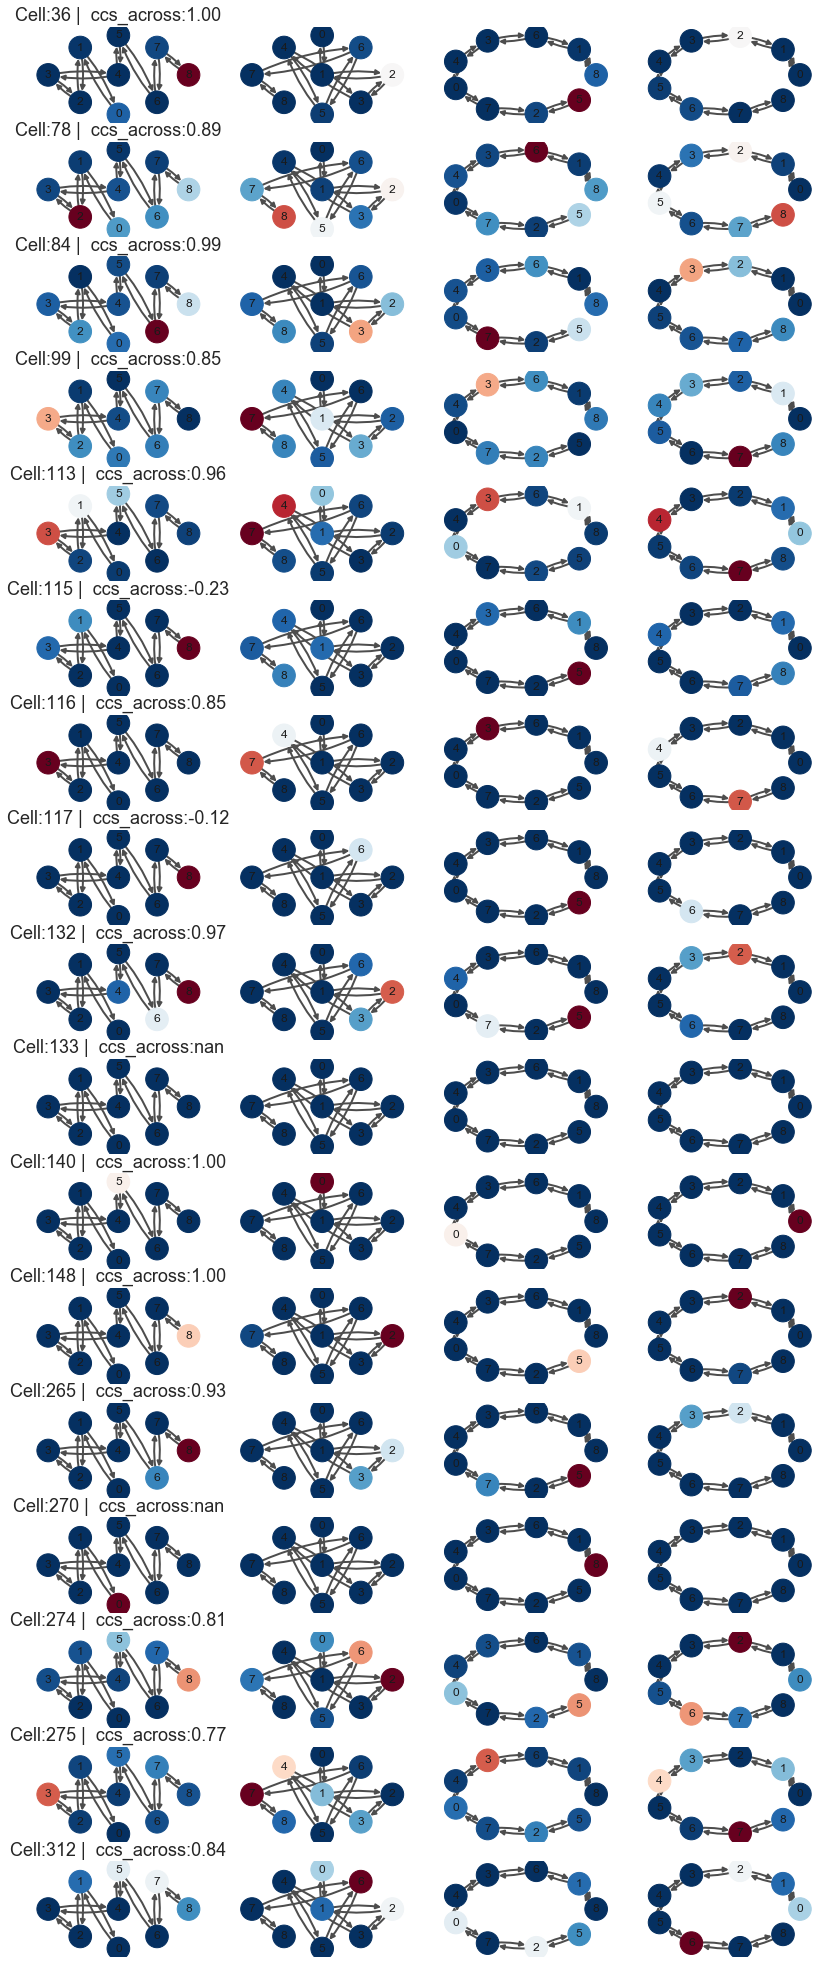

In [115]:
resps_state_g1 = all_resps_g1[:,all_poke_dict[0]['seq']]
resps_state_g2 = all_resps_g2[:,all_poke_dict[1]['seq']]
plt.figure(figsize=(14,84))

n_plot = 40
start = 0
ctr = 0
for i in [ 36,  78,  84,  99, 113, 115, 116, 117, 132, 133, 140, 148,
       265, 270, 274, 275, 312]:#range(len(ccs_within)):
    if True:#ccs_within[i]>0.3 and ccs_across[i]<0.6:
        spks1 = all_resps_g1[i]# - ( all_resps_g1[i]+ all_resps_g2[i])/2.
        spks2 = all_resps_g2[i]# - ( all_resps_g1[i]+ all_resps_g2[i])/2.
        mx = np.nanmax(np.concatenate([spks1,spks2]))
        mn = 0#np.nanmin(np.concatenate([spks1,spks2]))
        plt.subplot(n_plot,4,4*ctr+1)
        plt.title('Cell:{} |  ccs_across:{:.2f}'.format(i,ccs_across[i]))

        spks = spks1
        plot_activity_on_graph(all_poke_dict[0]['seq'],all_poke_dict[0]['graph_type'],
                               spks=spks,order='poke',mx=mx,mn=mn)
        
        plt.subplot(n_plot,4,4*ctr+2)
        spks = spks2
        plot_activity_on_graph(all_poke_dict[1]['seq'],all_poke_dict[1]['graph_type'],
                               spks=spks,order='poke',mx=mx,mn=mn)

        plt.subplot(n_plot,4,4*ctr+3)
        spks = resps_state_g1[i]
        plot_activity_on_graph(all_poke_dict[0]['seq'],all_poke_dict[0]['graph_type'],
                               spks=spks,order='state',mx=mx,mn=mn)
        
        plt.subplot(n_plot,4,4*ctr+4)
        spks = resps_state_g2[i]
        plot_activity_on_graph(np.arange(9).tolist(),all_poke_dict[1]['graph_type'],
                               spks=spks,order='state',mx=mx,mn=mn)

        ctr +=1

In [27]:
all_poke_dict[1]['seq']

[0, 4, 5, 7, 1, 8, 2, 3, 6]

In [418]:
spatial_transitions_square =  [[1,2],
                             [0,3,4],
                             [0,4,5],
                             [1,6],
                             [1,2,6,7],
                             [2,7],
                             [3,4,8],
                             [4,5,8],
                             [6,7]]

A = np.zeros([9,9])
for i,entries in enumerate(spatial_transitions_square):
    A[i,entries] = 1
    
D = np.sum(A,axis=1)
L = D*np.eye(len(D)) - A

evals,evecs = np.linalg.eig(L)
evals = evals.real

In [419]:
evals,evecs = np.linalg.eig(L)
evals = evals.real

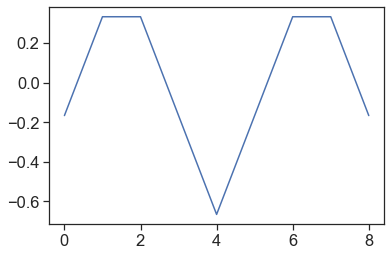

In [420]:
plt.plot(evecs[:,0])

In [421]:
def fit_sin2(x,*params):
    t_ = np.linspace(0,2*np.pi,9)
    y = np.array(params)
    y -= np.mean(y)
    y /=np.max(y)
    pred = np.cos(x[0]*t_ + x[1])
    cc = np.corrcoef(pred,y)[0,1]
    if np.isnan(cc): cc = -100
    return -cc

In [422]:
import numba
@numba.jit(nopython=True)
def fit_sin2(x,*params):
    #t_ = np.linspace(0,2*np.pi,9)
    y,t_ = params
    #y = np.array(params)
    #y -= np.mean(y)
    #y /=np.max(y)
    pred = np.cos(x[0]*t_ + x[1])
    cc = np_pearson_cor(pred,y)
    if np.isnan(cc): cc = -100
    return -cc


@numba.jit(nopython=True)
def np_pearson_cor(x, y):
    """ from 
        https://cancerdatascience.org/blog/posts/pearson-correlation/
    """
    xv = x - np.mean(x)
    yv = y - np.mean(y)
    xvss = np.sum(xv * xv)
    yvss = np.sum(yv * yv)
    result = np.dot(xv.T, yv) / np.sqrt(np.outer(xvss, yvss))
    # bound the values to -1 to 1 in the event of precision issues
    return result[0][0]# np.maximum(np.minimum(result, 1.0), -1.0)

In [423]:
print(all_poke_dict[1]['seq'])
print(all_poke_dict[0]['seq'])

[8, 4, 2, 5, 7, 0, 6, 1, 3]
[1, 3, 6, 0, 2, 8, 4, 7, 5]


In [424]:
#resps_state_g1 = all_resps_g1[:,all_poke_dict[0]['seq']]
#resps_state_g2 = all_resps_g2[:,all_poke_dict[1]['seq']]


mean_resps_state = (all_resps_g1 + all_resps_g2)/2.

resps_state_g1 = (all_resps_g1-mean_resps_state)[:,all_poke_dict[0]['seq']]
resps_state_g2 = (all_resps_g2-mean_resps_state)[:,all_poke_dict[1]['seq']]

In [459]:
np.roll(np.arange(9),0)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [425]:
#Add as control not just random shuffles but also shuffles according to the graph of the 
#other task and also physical space

resp_sets = [resps_state_g1,resps_state_g2]

t_ = np.linspace(0,2*np.pi,9)
NSHUFF = 20
params_ranges = [slice(0,4,.5),slice(0,2*np.pi,np.pi/9)]

n_neurons = resps_state_g1.shape[0]
print(n_neurons)

res_sets = []
ccs_sets = []
cc_shuff_sets = []
for neuron_ix in range(n_neurons):
    
    tmp_cc = []
    tmp_res = []
    tmp_cc_shuff = []
    for ix,resp_set in enumerate(resp_sets):    

        sys.stdout.write('\r running cell:{}'.format(neuron_ix))
        sys.stdout.flush()

        spks = resp_set[neuron_ix]
        res1 = op.brute(fit_sin2,params_ranges,args=(spks,t_),finish=None)

        
        cc1 = np.corrcoef(spks,np.cos(res1[0]*t_ + res1[1]))[0,1]

        cc1_shuff = []
        for _ in range(NSHUFF):
            spks_shuff = np.random.permutation(spks)
            res1_shuff = op.brute(fit_sin2,params_ranges,args=(spks_shuff,t_),finish=None)

            cc1_shuff.append(np.corrcoef(spks_shuff,np.cos(res1_shuff[0]*t_ + res1_shuff[1]))[0,1])

        tmp_cc.append(cc1)
        tmp_cc_shuff.append(cc1_shuff)
        tmp_res.append(res1)
    res_sets.append(tmp_res)
    ccs_sets.append(tmp_cc)
    cc_shuff_sets.append(tmp_cc_shuff)
    

135
 running cell:5

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


 running cell:134

In [426]:
ccs_sets = np.array(ccs_sets)
res_sets = np.array(res_sets)
cc_shuff_sets = np.array(cc_shuff_sets)

In [427]:
import scipy.stats as stt

In [428]:
cc_shuff_sets.shape

(135, 2, 20)

In [454]:
p_vals = []
for cell_ix,cell in enumerate(ccs_sets):
        tmp = []
        for task_nr in range(1):
            if True:#ccs_within[cell_ix]>-np.inf:
                #print(cell_ix)
                p1 = stt.percentileofscore(cc_shuff_sets[cell_ix][task_nr],cell[task_nr])
                #tmp.append(p1)
                p_vals.append([cell_ix,p1])

In [455]:
pvs_ = (np.array(p_vals)[:,1])
stt.binom_test(np.sum(pvs_>=95),len(pvs_),p=0.05)

0.008889862080386713

In [450]:

np.mean((np.array(p_vals)[:,1]>=95))

0.11428571428571428

In [461]:
cc_shuff_sets.shape

(135, 2, 20)

(0, 1.0586653394748022)

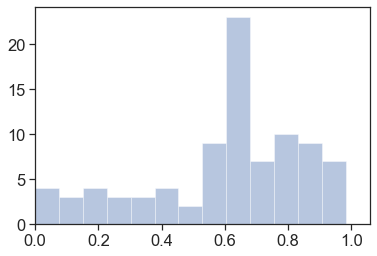

In [452]:
seaborn.distplot(ccs_both[0][np.isfinite(ccs_both[0])],kde=0,bins=20)
plt.xlim(0)

In [462]:
res_sets[:,0]

array([[2.        , 3.14159265],
       [0.        , 0.        ],
       [0.5       , 2.0943951 ],
       [2.        , 3.4906585 ],
       [2.5       , 3.14159265],
       [3.5       , 0.        ],
       [0.        , 0.        ],
       [2.        , 3.14159265],
       [1.        , 0.34906585],
       [2.5       , 1.3962634 ],
       [1.        , 3.4906585 ],
       [3.        , 1.04719755],
       [1.        , 4.53785606],
       [1.5       , 5.93411946],
       [3.        , 0.        ],
       [1.5       , 4.88692191],
       [2.        , 1.74532925],
       [1.        , 4.88692191],
       [2.5       , 1.74532925],
       [1.5       , 3.4906585 ],
       [1.5       , 4.1887902 ],
       [3.        , 0.6981317 ],
       [2.5       , 2.0943951 ],
       [1.5       , 4.53785606],
       [3.        , 1.3962634 ],
       [1.5       , 2.7925268 ],
       [0.5       , 1.3962634 ],
       [2.        , 3.83972435],
       [1.        , 2.44346095],
       [0.5       , 3.83972435],
       [3.

In [435]:
ccs_sets = np.array(ccs_sets)
res_t1 = np.array(res_sets[:,0])
res_t2 = np.array(res_sets[:,1])

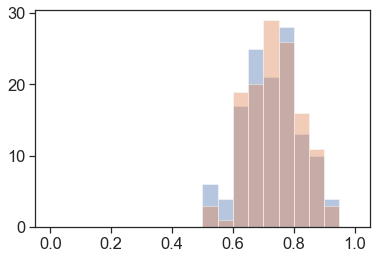

In [436]:
seaborn.distplot(ccs_sets[:,0][np.isfinite(ccs_sets[:,0])],kde=0,bins=np.linspace(0,1,num=21))
seaborn.distplot(ccs_sets[:,1][np.isfinite(ccs_sets[:,0])],kde=0,bins=np.linspace(0,1,num=21))

In [437]:
ixs = np.where(np.logical_and(ccs_sets[:,0]>0.6,ccs_sets[:,1]>0.6))[0]

[3. 0.]
[3.5        1.74532925]


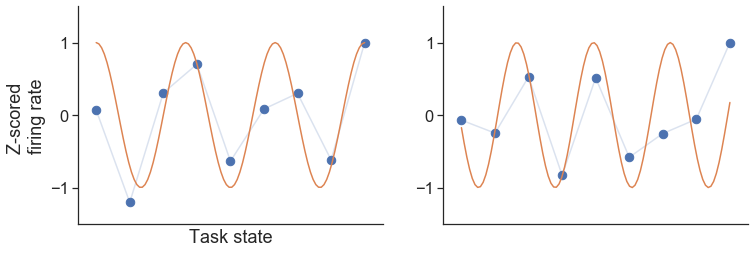

In [438]:
plt.figure(figsize=(12,4))
ix = 14
plt.subplot(1,2,1)
x = res_t1[ix]

t_ = np.linspace(0,2*np.pi,9)
y = np.array(resps_state_g1[ix])# - (np.array(resps_state_g1[ix])+np.array(resps_state_g2[ix]))/2.
y -= np.mean(y)
y /= np.max(y)
plt.ylabel("Z-scored \nfiring rate")
plt.xlabel("Task state")

pred = np.cos(x[0]*np.linspace(0,2*np.pi,num=100)+ x[1])#*x[2] + x[3]
#pred = np.cos(1*t_ + np.pi)*.5
print(x)


plt.plot(t_,y,alpha=.2,label='')
plt.scatter(t_,y,s=72)
plt.plot(np.linspace(0,2*np.pi,num=100),pred)
plt.ylim(-1.5,1.5)
plt.locator_params('y',nbins=3)

plt.xticks([])

plt.subplot(1,2,2)
x = res_t2[ix]

t_ = np.linspace(0,2*np.pi,9)
y = np.array(resps_state_g2[ix])# - (np.array(resps_state_g1[ix])+np.array(resps_state_g2[ix]))/2.
y -= np.mean(y)
y /= np.max(y)
pred = np.cos(x[0]*np.linspace(0,2*np.pi,num=100)+ x[1])#*x[2] + x[3]
#pred = np.cos(1*t_ + np.pi)*.5
print(x)

plt.plot(t_,y,alpha=.2)
plt.scatter(t_,y,s=72)
plt.plot(np.linspace(0,2*np.pi,num=100),pred)
plt.ylim(-1.5,1.5)
plt.locator_params('y',nbins=3)
plt.xticks([])
seaborn.despine()

[3. 0.]
[3.5        1.74532925]


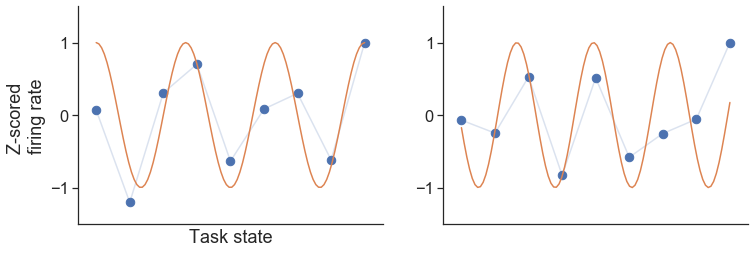

In [439]:
plt.figure(figsize=(12,4))
ix = 14
plt.subplot(1,2,1)
x = res_t1[ix]

t_ = np.linspace(0,2*np.pi,9)
y = np.array(resps_state_g1[ix])# - (np.array(resps_state_g1[ix])+np.array(resps_state_g2[ix]))/2.
y -= np.mean(y)
y /= np.max(y)
plt.ylabel("Z-scored \nfiring rate")
plt.xlabel("Task state")

pred = np.cos(x[0]*np.linspace(0,2*np.pi,num=100)+ x[1])#*x[2] + x[3]
#pred = np.cos(1*t_ + np.pi)*.5
print(x)


plt.plot(t_,y,alpha=.2,label='')
plt.scatter(t_,y,s=72)
plt.plot(np.linspace(0,2*np.pi,num=100),pred)
plt.ylim(-1.5,1.5)
plt.locator_params('y',nbins=3)

plt.xticks([])

plt.subplot(1,2,2)
x = res_t2[ix]

t_ = np.linspace(0,2*np.pi,9)
y = np.array(resps_state_g2[ix])# - (np.array(resps_state_g1[ix])+np.array(resps_state_g2[ix]))/2.
y -= np.mean(y)
y /= np.max(y)
pred = np.cos(x[0]*np.linspace(0,2*np.pi,num=100)+ x[1])#*x[2] + x[3]
#pred = np.cos(1*t_ + np.pi)*.5
print(x)

plt.plot(t_,y,alpha=.2)
plt.scatter(t_,y,s=72)
plt.plot(np.linspace(0,2*np.pi,num=100),pred)
plt.ylim(-1.5,1.5)
plt.locator_params('y',nbins=3)
plt.xticks([])
seaborn.despine()

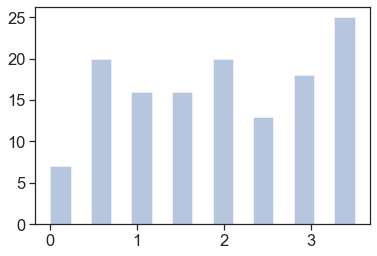

In [440]:
seaborn.distplot(res_t1[:,0],kde=0,bins=15)

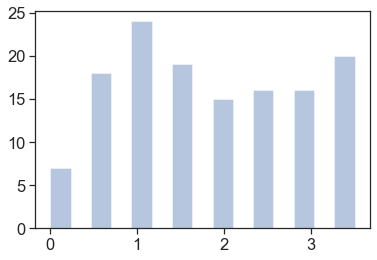

In [441]:
seaborn.distplot(res_t2[:,0],kde=0,bins=15)

(0, 4.6)

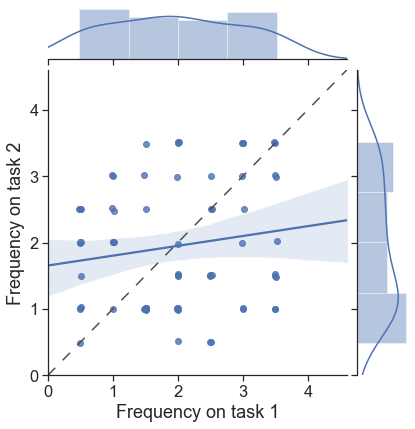

In [466]:
thresh = 0.
ixs = np.where(np.logical_and.reduce([np.logical_and(ccs_sets[:,0]>thresh,
                                                    ccs_sets[:,1]>thresh),
                                      ccs_within[:len(ccs_sets)]>0.0,
                                        np.array(p_vals)[:,1]>9,
                                     #np.logical_and(ccs_within1>thresh,
                                     #              ccs_within2>thresh),
                                    
                                     ]
                                    ))[0]

#ixs = np.where(np.any(np.array(p_vals)>95,axis=1))[0]
seaborn.jointplot(res_sets[:,0][ixs,0]+np.random.normal(loc=0,scale=0.01,size=len(ixs)),
                  res_sets[:,1][ixs,0]+np.random.normal(loc=0,scale=0.01,size=len(ixs)),
                  kind='reg')
plt.plot([0,4.6],[0,4.6],color='.3',dashes=(7,7))
plt.xlabel("Frequency on task 1")
plt.ylabel("Frequency on task 2")
plt.xlim(0,4.6)
plt.ylim(0,4.6)

In [468]:
res_sets[:,0][ixs,0].shape

(68,)

In [473]:
res_sets.shape

(135, 2, 2)

In [471]:
res_sets[:,0]

(135, 2, 2)

In [443]:
true_pop_cc = np.corrcoef(res_sets[:,0][ixs,0],res_sets[:,1][ixs,0])[0,1]
print(true_pop_cc)

0.15756591044632862


In [444]:
sys.path.append("/Users/yves/Documents/Code/")

In [445]:
import yutils

In [446]:
yutils.cc_pval(res_sets[:,0][ixs,0],res_sets[:,1][ixs,0])

(0.15756591044632862, 90.72)

In [326]:
resps_state_g1 = all_resps_g1[:,all_poke_dict[0]['seq']]
resps_state_g2 = all_resps_g2[:,all_poke_dict[1]['seq']]


In [149]:
import numba

In [205]:
@numba.jit(nopython=True)
def fit_sin2(x,*params):
    #t_ = np.linspace(0,2*np.pi,9)
    y,t_ = params
    #y = np.array(params)
    #y -= np.mean(y)
    #y /=np.max(y)
    pred = np.cos(x[0]*t_ + x[1])
    cc = np_pearson_cor(pred,y)
    if np.isnan(cc): cc = -100
    return -cc


@numba.jit(nopython=True)
def np_pearson_cor(x, y):
    """ from 
        https://cancerdatascience.org/blog/posts/pearson-correlation/
    """
    xv = x - np.mean(x)
    yv = y - np.mean(y)
    xvss = np.sum(xv * xv)
    yvss = np.sum(yv * yv)
    result = np.dot(xv.T, yv) / np.sqrt(np.outer(xvss, yvss))
    # bound the values to -1 to 1 in the event of precision issues
    return result[0][0]# np.maximum(np.minimum(result, 1.0), -1.0)

In [206]:
@numba.jit(nopython=True)
def np_pearson_cor(x, y):
    """ from 
        https://cancerdatascience.org/blog/posts/pearson-correlation/
    """
    xv = x - np.mean(x)
    yv = y - np.mean(y)
    xvss = np.sum(xv * xv)
    yvss = np.sum(yv * yv)
    result = np.dot(xv.T, yv) / np.sqrt(np.outer(xvss, yvss))
    # bound the values to -1 to 1 in the event of precision issues
    return result[0][0]# np.maximum(np.minimum(result, 1.0), -1.0)

In [191]:
a = np.random.normal(size=100)
b = np.random.normal(size=100)

In [192]:
np.corrcoef(a,b)

array([[ 1.        , -0.05316172],
       [-0.05316172,  1.        ]])

In [193]:
np.sum(xv * xv)

0.001422222222222222

In [194]:
(np_pearson_cor(spks_shuff,spks_shuff))

1.0

In [195]:
x = spks_shuff
y = spks_shuff
xv = x - x.mean(axis=0)
yv = y - y.mean(axis=0)
xvss = (xv * xv).sum(axis=0)
yvss = (yv * yv).sum(axis=0)


In [196]:
np.matmul(xv.T, yv)

0.0014222222222222223

In [201]:
def fit_sin2(x,*params):
    t_ = np.linspace(0,2*np.pi,9)
    y = np.array(params)
    y -= np.mean(y)
    y /=np.max(y)
    pred = np.cos(x[0]*t_ + x[1])
    cc = np.corrcoef(pred,y)[0,1]
    if np.isnan(cc): cc = -100
    return -cc

In [211]:
st = time.time()
NSHUFF = 500
y1 = resps_state_g1[i]
y2 = resps_state_g2[i]
spks = y1
params_ranges = [slice(0,4,.25),slice(0,np.pi,np.pi/9)]
t_ = np.linspace(0,2*np.pi,9)

cc1_shuff22 = []
np.random.seed(100)
for _ in range(NSHUFF):
    spks_shuff = np.random.permutation(spks)
    res1_shuff = op.brute(fit_sin2,params_ranges,args=(np.array(spks_shuff),t_),finish=None)
    cc1_shuff22.append(np.corrcoef(spks_shuff,np.cos(res1_shuff[0]*t_ + res1_shuff[1]))[0,1])

print('elapsed time: {:.2f}s'.format(time.time()-st))

elapsed time: 0.35s


In [208]:
0.89*300

267.0

In [199]:
cc1_shuff

[0.5394270560579761,
 0.5533956232437972,
 0.7235568736461421,
 0.5819570122317161,
 0.5817276748033771,
 0.7676514390459839,
 0.5533956232437972,
 0.5819570122317161,
 0.5394270560579761,
 0.7235568736461421,
 0.5819570122317161,
 0.7235568736461421,
 0.7235568736461421,
 0.5393611763359221,
 0.6258697114083546,
 0.5394270560579761,
 0.6258697114083546,
 0.5394270560579761,
 0.5819570122317161,
 0.5819570122317161,
 0.5783440156374952,
 0.5783440156374952,
 0.5817276748033771,
 0.5819570122317161,
 0.5394270560579761,
 0.5819570122317161,
 0.6258697114083546,
 0.5393611763359221,
 0.6258697114083546,
 0.5819570122317161,
 0.7676514390459839,
 0.7676514390459839,
 0.5783440156374952,
 0.5819570122317161,
 0.5817276748033771,
 0.5394270560579761,
 0.5393611763359221,
 0.5393611763359221,
 0.5394270560579761,
 0.5817276748033771,
 0.5817276748033771,
 0.5394270560579761,
 0.5394270560579761,
 0.7235568736461421,
 0.5394270560579761,
 0.7676514390459839,
 0.6258697114083546,
 0.5819570122